In [14]:
# We need more packages!
# Data science
import pandas as pd
print(f"Pandas: {pd.__version__}")
import numpy as np
print(f"Numpy: {np.__version__}")

# Unsupervised Learning
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from zeugma.embeddings import EmbeddingTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from sklearn.metrics import silhouette_score, silhouette_samples

# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
from sklearn.manifold import TSNE

# Word Embeddings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer
import gensim
print(f'gensim: {gensim.__version__}')

# Doc2Vec
from nltk.tokenize import word_tokenize 
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

# Storing as objects via serialization
from tempfile import mkdtemp
import pickle
import joblib

# Directory
import os
import yaml

# Cool progress bars
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()  # Enable tracking of execution progress

# # Reading in intents
# with open(r'objects/intents.yml') as file:
#     intents = yaml.load(file, Loader=yaml.FullLoader)

processed_inbound = pd.read_pickle('/kaggle/input/chatbot-data/processed_inbound.pkl')

string_processed_inbound = processed_inbound.progress_apply(" ".join)
processed_inbound.head()

Pandas: 2.0.3
Numpy: 1.23.5
gensim: 4.3.2


/tmp/ipykernel_28/3638686843.py:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()  # Enable tracking of execution progress


0it [00:00, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

0          What does it mean to have a mental illness?
1                      Who does mental illness affect?
2                          What causes mental illness?
3    What are some of the warning signs of mental i...
4              Can people with mental illness recover?
Name: Real Inbound, dtype: string

In [4]:
# !pip install zeugma 

In [16]:
string_processed_inbound

0     W h a t   d o e s   i t   m e a n   t o   h a ...
1     W h o   d o e s   m e n t a l   i l l n e s s ...
2     W h a t   c a u s e s   m e n t a l   i l l n ...
3     W h a t   a r e   s o m e   o f   t h e   w a ...
4     C a n   p e o p l e   w i t h   m e n t a l   ...
                            ...                        
93    H o w   d o   I   k n o w   i f   I ' m   d r ...
94    I f   c a n n a b i s   i s   d a n g e r o u ...
95    H o w   c a n   I   c o n v i n c e   m y   k ...
96    W h a t   i s   t h e   l e g a l   s t a t u ...
97    W h a t   i s   t h e   e v i d e n c e   o n ...
Name: Real Inbound, Length: 98, dtype: object

In [18]:
import string
import pandas as pd


def remove_punctuation(input_string):
    # Define a translation table to remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    
    # Use the translate method to remove punctuation
    cleaned_string = input_string.translate(translator)
    
    return cleaned_string

# Apply the remove_punctuation function to each element of the Series
string_processed_inbound = processed_inbound.apply(remove_punctuation)
print(string_processed_inbound)


0            What does it mean to have a mental illness
1                        Who does mental illness affect
2                            What causes mental illness
3     What are some of the warning signs of mental i...
4                Can people with mental illness recover
                            ...                        
93                How do I know if Im drinking too much
94    If cannabis is dangerous why are we legalizing it
95          How can I convince my kids not to use drugs
96     What is the legal status and evidence of CBD oil
97                       What is the evidence on vaping
Name: Real Inbound, Length: 98, dtype: object


In [19]:
import spacy

# Load the English language model
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(input_text):
    # Process the input text with spaCy
    doc = nlp(input_text)
    
    # Lemmatize each token and join them back into a sentence
    lemmatized_text = ' '.join([token.lemma_ for token in doc])
    
    return lemmatized_text

# Example usage:
import pandas as pd

# Apply the lemmatize_text function to each element of the Series
string_processed_inbound = string_processed_inbound.apply(lemmatize_text)
print(string_processed_inbound)


0              what do it mean to have a mental illness
1                          who do mental illness affect
2                             what cause mental illness
3     what be some of the warning sign of mental ill...
4                can people with mental illness recover
                            ...                        
93                  how do I know if I m drink too much
94       if cannabis be dangerous why be we legalize it
95            how can I convince my kid not to use drug
96     what be the legal status and evidence of cbd oil
97                         what be the evidence on vape
Name: Real Inbound, Length: 98, dtype: object


In [26]:
import spacy

# Load the English language model
nlp = spacy.load("en_core_web_sm")

def remove_stop_words(input_text):
    doc = nlp(input_text)
    cleaned_text = ' '.join([token.text for token in doc if not token.is_stop])
    return cleaned_text

import pandas as pd

# Apply the remove_stop_words function to each element of the Series
string_processed_inbound = string_processed_inbound.apply(remove_stop_words)
print(string_processed_inbound)


0               mean mental illness
1             mental illness affect
2              cause mental illness
3       warning sign mental illness
4     people mental illness recover
                  ...              
93                     know m drink
94      cannabis dangerous legalize
95            convince kid use drug
96    legal status evidence cbd oil
97                    evidence vape
Name: Real Inbound, Length: 98, dtype: object


In [ ]:
# string_processed_inbound.to_pickle()

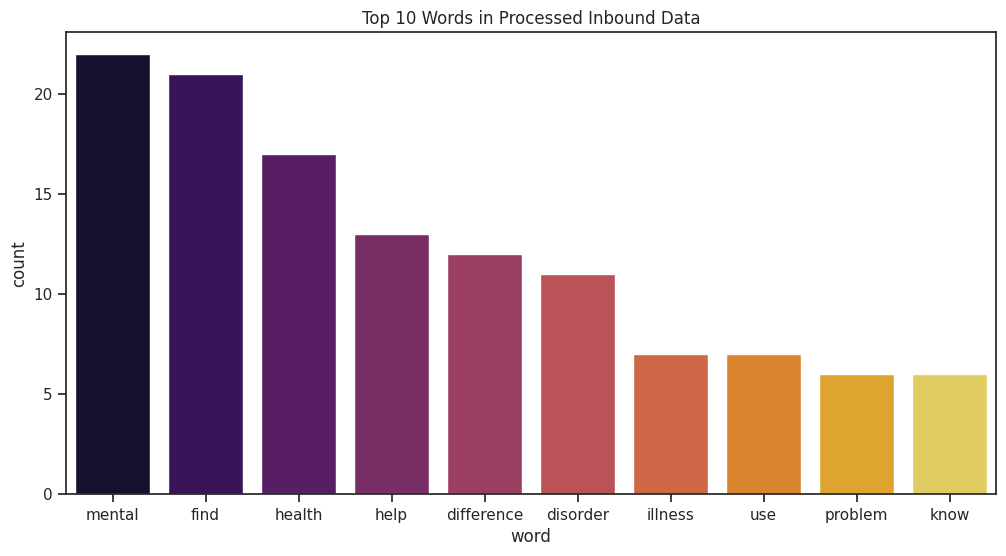

In [27]:
# Vectorizing the data with Count Vectorizer
bagofwords = CountVectorizer(min_df = 5).fit(string_processed_inbound)
inbound_cv = bagofwords.transform(string_processed_inbound)

# For visualizing top 10
def top10_bagofwords(data, output_name, title):
    ''' Taking as input the data and plots the top 10 words based on counts in this text data'''
    bagofwords = CountVectorizer()
    # Output will be a sparse matrix
    inbound = bagofwords.fit_transform(data)
    # Inspecting of often contractions and colloquial language is used
    word_counts = np.array(np.sum(inbound, axis=0)).reshape((-1,))
    words = np.array(bagofwords.get_feature_names_out())
    words_df = pd.DataFrame({"word":words, 
                             "count":word_counts})
    words_rank = words_df.sort_values(by="count", ascending=False)
    # words_rank.to_csv('words_rank.csv') # Storing it in a csv so I can inspect and go through it myself
    words_rank.head()
    # Visualizing top 10 words
    plt.figure(figsize=(12,6))
    sns.barplot(x=words_rank['word'][:10], y=words_rank['count'][:10], palette = 'inferno')
    plt.title(title)
    
    # Saving
    plt.savefig(f'visualizationsoutput_name.png')
    
    plt.show()


top10_bagofwords(string_processed_inbound, 'initial_frequencies', 'Top 10 Words in Processed Inbound Data')

In [28]:
tfidf = TfidfVectorizer(min_df=5, ngram_range = (1,3))
# Storing tfidf data and transforming them into sparse matrices
inbound_tfidf = tfidf.fit_transform(string_processed_inbound)
inbound_tfidf

<98x18 sparse matrix of type '<class 'numpy.float64'>'
	with 171 stored elements in Compressed Sparse Row format>

In [31]:
pd.Series(string_processed_inbound).to_pickle("string_processed_inboundv2.pickel")

In [32]:
glove = EmbeddingTransformer('glove')
# Applying it to the entire training data
inbound_glove = string_processed_inbound.progress_apply(glove.transform)
# Preview shapes
inbound_glove.iloc[0].shape, inbound_glove.iloc[1].shape

[==================================================] 100.0% 104.8/104.8MB downloaded


  0%|          | 0/98 [00:00<?, ?it/s]

((19, 25), (21, 25))

In [33]:
similarity = cosine_similarity(inbound_glove.iloc[0], inbound_glove.iloc[1])
similarity

array([[1.        , 0.7186241 , 0.7816931 , 0.95267564, 0.75744706,
        0.95910853, 0.        , 0.6628703 , 0.95910853, 0.95910853,
        0.7816931 , 0.7186241 , 0.9671342 , 0.9671342 , 0.        ,
        0.75744706, 0.94571257, 0.94571257, 0.7186241 , 0.9260939 ,
        0.95267564],
       [0.7186241 , 1.0000001 , 0.64597446, 0.6358681 , 0.717424  ,
        0.67923963, 0.        , 0.5385777 , 0.67923963, 0.67923963,
        0.64597446, 1.0000001 , 0.7754639 , 0.7754639 , 0.        ,
        0.717424  , 0.670958  , 0.670958  , 1.0000001 , 0.77891517,
        0.6358681 ],
       [0.75744706, 0.717424  , 0.5505018 , 0.7374065 , 1.0000001 ,
        0.7501674 , 0.        , 0.7231824 , 0.7501674 , 0.7501674 ,
        0.5505018 , 0.717424  , 0.8014316 , 0.8014316 , 0.        ,
        1.0000001 , 0.73373353, 0.73373353, 0.717424  , 0.8116697 ,
        0.7374065 ],
       [0.7816931 , 0.64597446, 0.9999999 , 0.7225855 , 0.5505018 ,
        0.8105063 , 0.        , 0.54344666, 0.8105063

In [34]:
inbound_cv, inbound_tfidf


(<98x14 sparse matrix of type '<class 'numpy.int64'>'
 	with 140 stored elements in Compressed Sparse Row format>,
 <98x18 sparse matrix of type '<class 'numpy.float64'>'
 	with 171 stored elements in Compressed Sparse Row format>)

In [35]:
# Fitting and transforming to create standard scaled versions of my data
inbound_cv_ma = MaxAbsScaler().fit_transform(inbound_cv)
inbound_tfidf_ma = MaxAbsScaler().fit_transform(inbound_cv)

inbound_cv_ma, inbound_tfidf_ma

(<98x14 sparse matrix of type '<class 'numpy.float64'>'
 	with 140 stored elements in Compressed Sparse Row format>,
 <98x14 sparse matrix of type '<class 'numpy.float64'>'
 	with 140 stored elements in Compressed Sparse Row format>)

In [36]:
# Vectorized data
vectorized_data = {'inbound_cv_ma': inbound_cv_ma, 'inbound_tfidf_ma': inbound_tfidf_ma}
# Briefly showing the contents of i and j
for i,j in enumerate(vectorized_data.items()): print(i,j);

0 ('inbound_cv_ma', <98x14 sparse matrix of type '<class 'numpy.float64'>'
	with 140 stored elements in Compressed Sparse Row format>)
1 ('inbound_tfidf_ma', <98x14 sparse matrix of type '<class 'numpy.float64'>'
	with 140 stored elements in Compressed Sparse Row format>)


In [64]:
import os

# Define the folder path
folder_path = "/kaggle/working/kmeans"
# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)


In [65]:
%%time
# My grand dictionaries that will store all my results
wcss_grand = {}
labels_grand = {}
silhouette_scores_grand = {}
n_clusters = [2 , 4 , 6, 8, 10 , 12 , 14 ]


# Iterating through all the differently embedded data
for i,j in tqdm(enumerate(vectorized_data.items())): 
    name = j[0] # Here j[0] is the name of the dataset
    dataset = j[1] # And j[1] is the actual data
    
    # I store my metrics at these following lists
    wcss = []
    labels = []
    silhouette_scores = []
    
    # Looping through values of k
    for k in tqdm(n_clusters):    
        print(f'Currently fitting {name} with {k} clusters... Please wait')
        
        # Initializing with k-means++ ensures that you get don’t fall into the random initialization trap.
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state = 10)
        kmeans.fit(dataset)
        wcss.append(kmeans.inertia_)
        
        # Getting the silhouette score
        labels.append(kmeans.labels_)
        silhouette_scores.append(silhouette_score(dataset, kmeans.labels_))
        
        # Saving the models
        filename = f'/kaggle/working/kmeans/{name}-{k}neighbors.sav'
        joblib.dump(kmeans, filename)
        
    # Updating grand dictionary
    wcss_grand[name + '_wcss'] = wcss
    labels_grand[name + '_labels'] = labels
    silhouette_scores_grand[name + '_silhouettes'] = silhouette_scores

# Saving all my results
with open('wcss_grand.pkl', 'wb') as handle:
    pickle.dump(wcss_grand, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('labels_grand.pkl', 'wb') as handle:
    pickle.dump(labels_grand, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('silhouette_scores_grand.pkl', 'wb') as handle:
    pickle.dump(silhouette_scores_grand, handle, protocol=pickle.HIGHEST_PROTOCOL)

<timed exec>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

<timed exec>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/7 [00:00<?, ?it/s]

Currently fitting inbound_cv_ma with 2 clusters... Please wait
Currently fitting inbound_cv_ma with 4 clusters... Please wait
Currently fitting inbound_cv_ma with 6 clusters... Please wait
Currently fitting inbound_cv_ma with 8 clusters... Please wait
Currently fitting inbound_cv_ma with 10 clusters... Please wait
Currently fitting inbound_cv_ma with 12 clusters... Please wait
Currently fitting inbound_cv_ma with 14 clusters... Please wait


<timed exec>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/7 [00:00<?, ?it/s]

Currently fitting inbound_tfidf_ma with 2 clusters... Please wait
Currently fitting inbound_tfidf_ma with 4 clusters... Please wait
Currently fitting inbound_tfidf_ma with 6 clusters... Please wait
Currently fitting inbound_tfidf_ma with 8 clusters... Please wait
Currently fitting inbound_tfidf_ma with 10 clusters... Please wait
Currently fitting inbound_tfidf_ma with 12 clusters... Please wait
Currently fitting inbound_tfidf_ma with 14 clusters... Please wait
CPU times: user 1.73 s, sys: 11.7 ms, total: 1.74 s
Wall time: 931 ms


In [66]:
# Storing it into objects I can use in this notebook

with open('wcss_grand.pkl', 'rb') as handle:
    wcss_grand = pickle.load(handle)
with open('labels_grand.pkl','rb') as handle:
    labels_grand = pickle.load(handle)
with open('silhouette_scores_grand.pkl','rb') as handle:
    silhouette_scores_grand = pickle.load(handle)

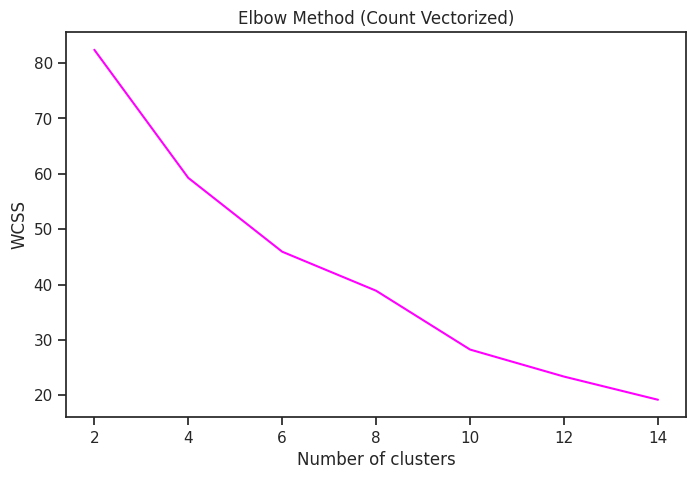

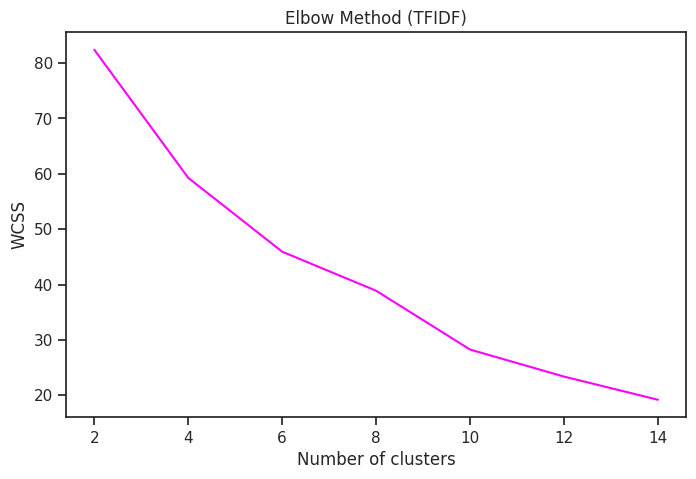

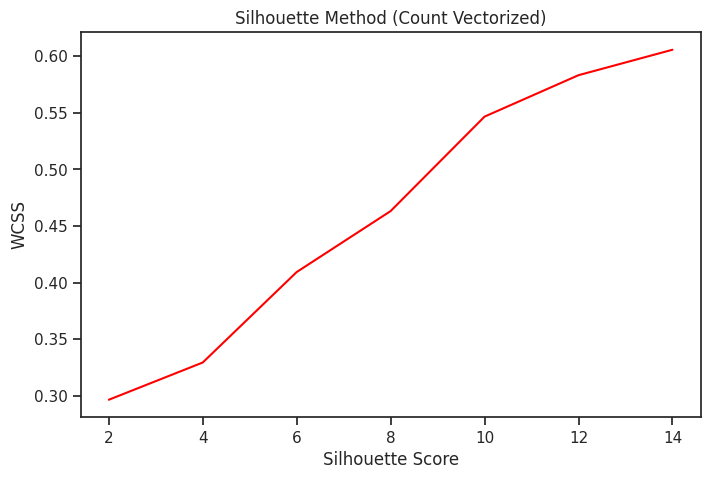

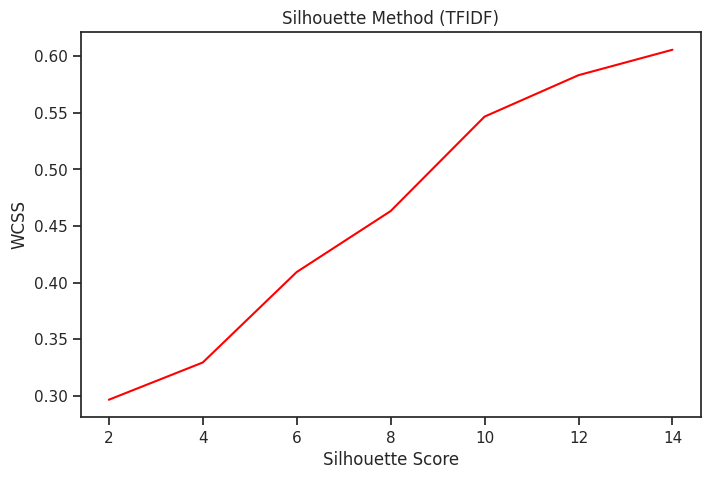

In [68]:
# Elbow Plot count vectorized
plt.figure(figsize=(8,5))
plt.plot(range(2, 16 , 2), wcss_grand['inbound_cv_ma_wcss'], color='magenta')
plt.title('Elbow Method (Count Vectorized)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Elbow Plot tfidf
plt.figure(figsize=(8,5))
plt.plot(range(2, 16 , 2), wcss_grand['inbound_tfidf_ma_wcss'], color = 'magenta')
plt.title('Elbow Method (TFIDF)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Silouette Plot count vectorized
plt.figure(figsize=(8,5))
plt.plot(range(2, 16 , 2), silhouette_scores_grand['inbound_cv_ma_silhouettes'], color = 'red')
plt.title('Silhouette Method (Count Vectorized)')
plt.xlabel('Silhouette Score')
plt.ylabel('WCSS')
plt.show()

# Silouette Plot tfidf
plt.figure(figsize=(8,5))
plt.plot(range(2, 16 , 2), silhouette_scores_grand['inbound_tfidf_ma_silhouettes'], color = 'red')
plt.title('Silhouette Method (TFIDF)')
plt.xlabel('Silhouette Score')
plt.ylabel('WCSS')
plt.show()

In [69]:
# Current data
inbound_cv_ma.shape, inbound_tfidf_ma.shape

((98, 14), (98, 14))

In [70]:
%time
# Instantiate t-SNE
tsne = TSNE(n_components=2, init='random', n_jobs=-1)

# Fit t-SNE
inbound_cv_ma_tsne = tsne.fit_transform(inbound_cv_ma)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


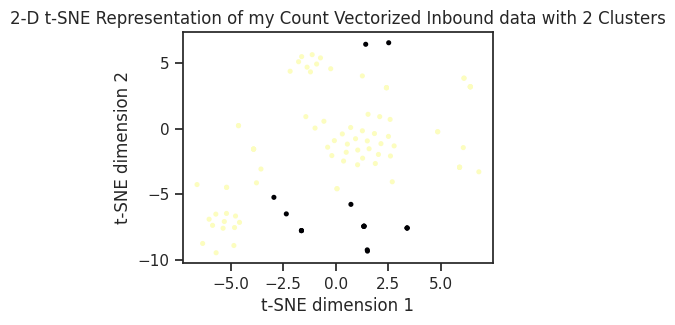

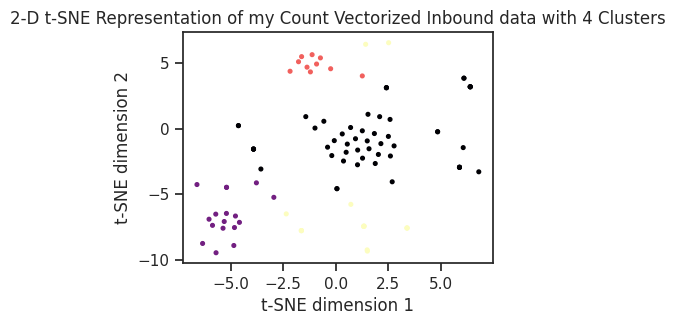

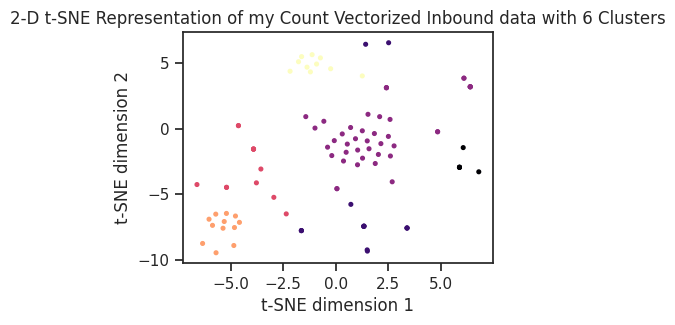

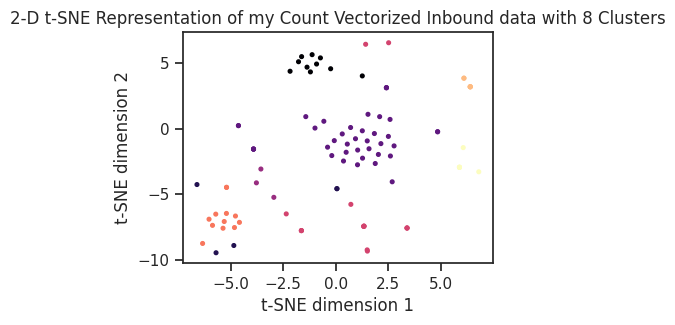

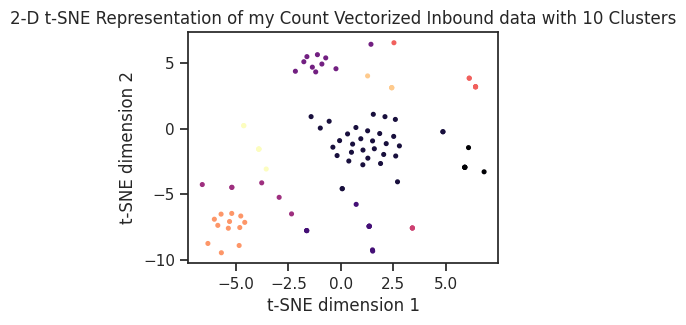

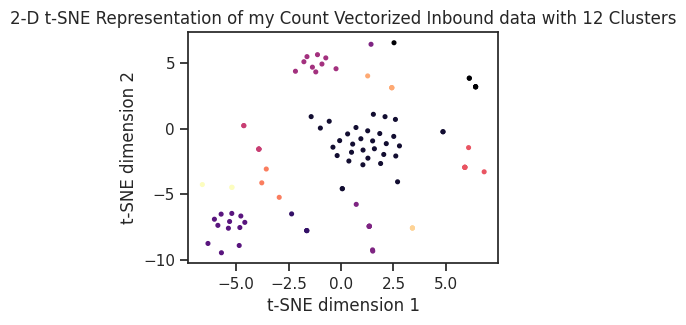

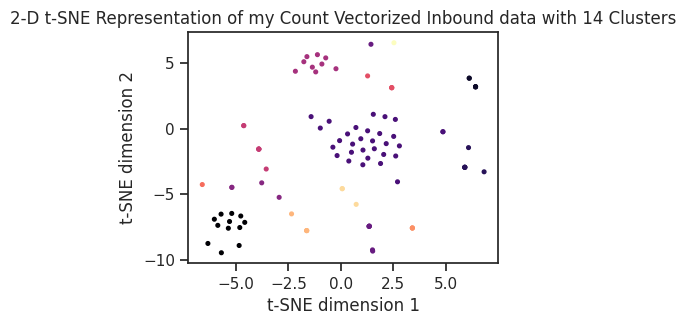

In [75]:
for k in range(2,16 ,2 ):
    # Getting the right K-Means cluster labels.
    labels = joblib.load(f'/kaggle/working/kmeans/inbound_cv_ma-{str(k)}neighbors.sav').labels_
    
    # Visualize high-dimensional data
    plt.figure(figsize=(4,3))
    plt.scatter(inbound_cv_ma_tsne[:,0], inbound_cv_ma_tsne[:,1], s=7, c = labels, cmap = 'magma')
    plt.title(f'2-D t-SNE Representation of my Count Vectorized Inbound data with {k} Clusters')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.show()

In [77]:
%time
# Instantiate t-SNE
tsne = TSNE(n_components=2, init="random", n_jobs=-1)

# Fit t-SNE
inbound_tfidf_ma_tsne = tsne.fit_transform(inbound_tfidf_ma)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


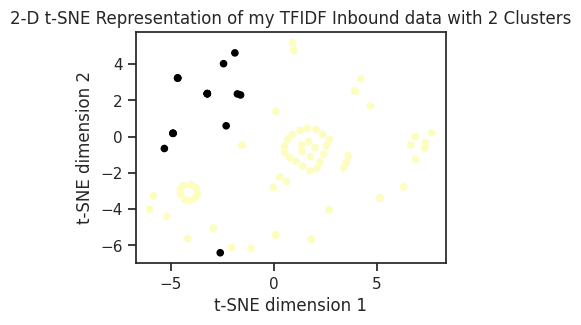

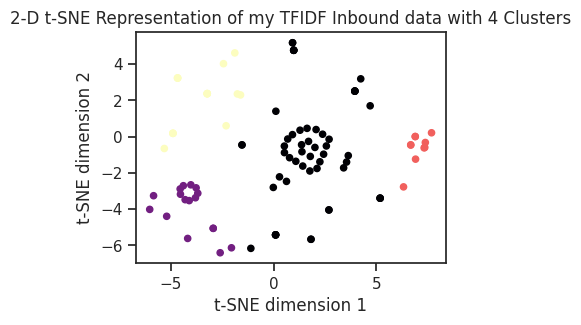

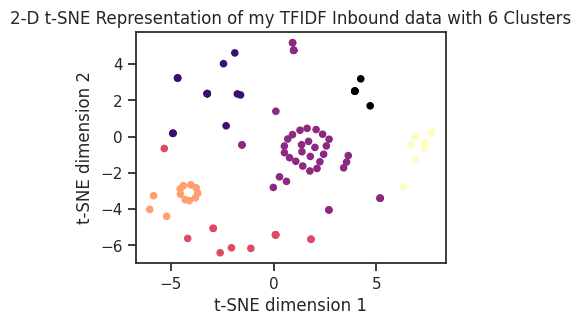

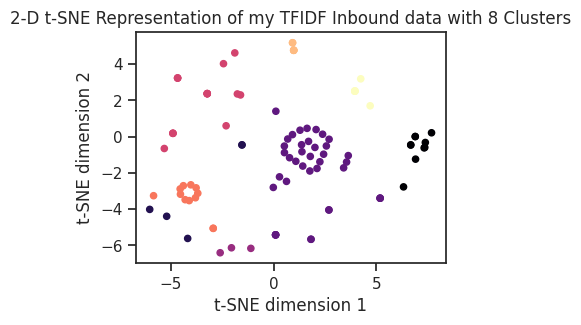

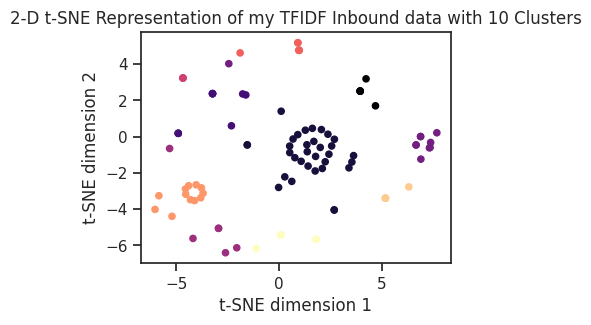

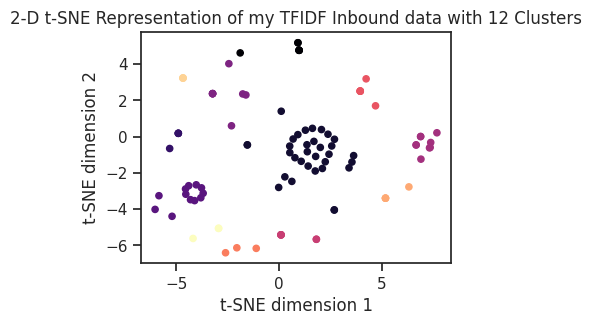

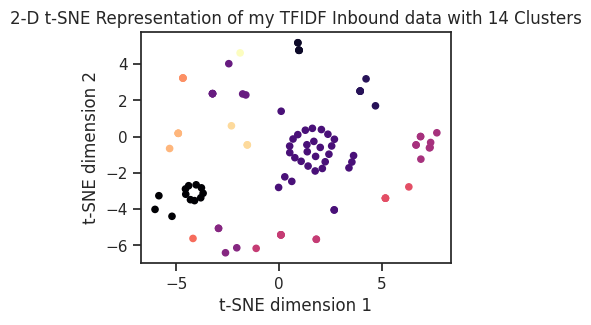

In [80]:
# Plotting my visualization for each of my n_neighbors with my tfidf data

for k in range(2 , 16  , 2):
    # Getting the right K-Means cluster labels.
    labels = joblib.load(f'/kaggle/working/kmeans/inbound_cv_ma-{str(k)}neighbors.sav').labels_
    
    # Visualize high-dimensional data
    plt.figure(figsize=(4 ,3 ))
    plt.scatter(inbound_tfidf_ma_tsne[:,0], inbound_tfidf_ma_tsne[:,1], s=20, c = labels, cmap = 'magma')
    plt.title(f'2-D t-SNE Representation of my TFIDF Inbound data with {k} Clusters')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.show()

In [113]:
# Vectorized data
# vectorized_data = {'inbound_cv_d2v':  inbound_d2v }
# # Briefly showing the contents of i and j
# for i,j in enumerate(vectorized_data.items()): print(i,j);

In [93]:
vectorized_data['inbound_cv_ma']

<98x14 sparse matrix of type '<class 'numpy.float64'>'
	with 140 stored elements in Compressed Sparse Row format>

In [99]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Tokenized data (already processed)
tokenized_data = [doc.split() for doc in string_processed_inbound]

# Create tagged documents with unique identifiers (tags)
tagged_data = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(tokenized_data)]

# Create and train a Doc2Vec model
model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4, epochs=10)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Infer vectors for the data
inbound_cv_ma_embeddings = [model.infer_vector(doc) for doc in tokenized_data]



In [102]:
vectorized_data = {'inbound_cv_d2v':  inbound_cv_ma_embeddings }

for i,j in enumerate(vectorized_data.items()): print(i,j);

0 ('inbound_cv_d2v', [array([-0.01620533, -0.01187474,  0.00392902,  0.01876991,  0.01383099,
        0.00852289, -0.01584836, -0.00607238,  0.02432151,  0.02364934,
       -0.00575185,  0.00512732,  0.0027804 , -0.01733135,  0.02091012,
        0.00132292, -0.00133167, -0.00672665, -0.00856148,  0.004077  ],
      dtype=float32), array([-0.02330549,  0.01848068, -0.01215747, -0.00573534,  0.00832649,
       -0.00859182, -0.01523987,  0.00431399,  0.02041796, -0.00402349,
       -0.00721433,  0.02045454, -0.01854218, -0.01601002,  0.01405899,
        0.00387537, -0.00721899, -0.0185149 , -0.01592756, -0.00842817],
      dtype=float32), array([ 0.00184374,  0.02075657,  0.01546057,  0.00978591,  0.02189013,
        0.00522074,  0.00059159, -0.00780188, -0.00941465,  0.01860384,
       -0.00312852,  0.02117903,  0.02132376,  0.00306433, -0.02368613,
       -0.00769753, -0.00602214,  0.01106378, -0.01011423,  0.00606674],
      dtype=float32), array([ 0.0060676 , -0.015286  ,  0.02503967,

In [104]:
# My d2v dictionaries that will store all my results
wcss_d2v = {}
labels_d2v = {}
silhouette_scores_d2v = {}
n_clusters = [2 ,4,6,8,10,12,14]

# Iterating through all the differently embedded data
for i,j in tqdm(enumerate(vectorized_data.items())): 
    name = j[0] # Here j[0] is the name of the dataset
    dataset = j[1] # And j[1] is the actual data
    
    # I store my metrics at these following lists
    wcss = []
    labels = []
    silhouette_scores = []
    
    # Looping through values of k
    for k in tqdm(n_clusters):    
        print(f'Currently fitting {name} with {k} clusters... Please wait')
        
        # Initializing with k-means++ ensures that you get don’t fall into the random initialization trap.
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state = 10)
        kmeans.fit(dataset)
        wcss.append(kmeans.inertia_)
        
        # Getting the silhouette score
        labels.append(kmeans.labels_)
        silhouette_scores.append(silhouette_score(dataset, kmeans.labels_))
        
        # Saving the models
        filename = f'/kaggle/working/kmeans{name}-{k}neighbors.sav'
        joblib.dump(kmeans, filename)
        
    # Updating d2v dictionary
    wcss_d2v[name + '_wcss'] = wcss
    labels_d2v[name + '_labels'] = labels
    silhouette_scores_d2v[name + '_silhouettes'] = silhouette_scores

# Saving all my results, now with a d2v tag
with open('objects:wcss_d2v.pkl', 'wb') as handle:
    pickle.dump(wcss_d2v, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('objects:labels_d2v.pkl', 'wb') as handle:
    pickle.dump(labels_d2v, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('objects:silhouette_scores_d2v.pkl', 'wb') as handle:
    pickle.dump(silhouette_scores_d2v, handle, protocol=pickle.HIGHEST_PROTOCOL)

/tmp/ipykernel_28/1950985104.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,j in tqdm(enumerate(vectorized_data.items())):


0it [00:00, ?it/s]

/tmp/ipykernel_28/1950985104.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm(n_clusters):


  0%|          | 0/7 [00:00<?, ?it/s]

Currently fitting inbound_cv_d2v with 2 clusters... Please wait
Currently fitting inbound_cv_d2v with 4 clusters... Please wait
Currently fitting inbound_cv_d2v with 6 clusters... Please wait
Currently fitting inbound_cv_d2v with 8 clusters... Please wait
Currently fitting inbound_cv_d2v with 10 clusters... Please wait
Currently fitting inbound_cv_d2v with 12 clusters... Please wait
Currently fitting inbound_cv_d2v with 14 clusters... Please wait


In [114]:
# Storing it into objects I can use in this notebook

with open('objects:wcss_d2v.pkl', 'rb') as handle:
    wcss_d2v = pickle.load(handle)
with open('objects:labels_d2v.pkl','rb') as handle:
    labels_d2v = pickle.load(handle)
with open('objects:silhouette_scores_d2v.pkl','rb') as handle:
    silhouette_scores_d2v = pickle.load(handle)

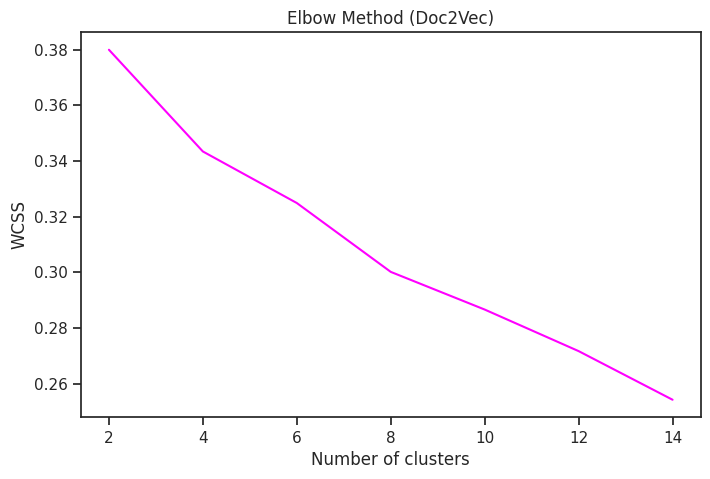

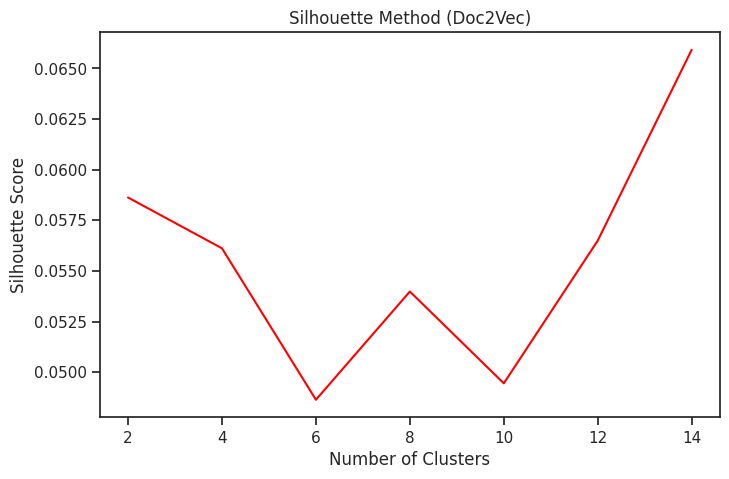

In [115]:
# Elbow Plot d2v
plt.figure(figsize=(8,5))
plt.plot(range(2, 16 , 2), wcss_d2v['inbound_cv_d2v_wcss'], color = 'magenta')
plt.title('Elbow Method (Doc2Vec)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Silouette Plot d2v
plt.figure(figsize=(8,5))
plt.plot(range(2, 16 , 2), silhouette_scores_d2v['inbound_cv_d2v_silhouettes'], color = 'red')
plt.title('Silhouette Method (Doc2Vec)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [116]:
%%time
# Convert the list of embeddings to a NumPy array
inbound_cv_ma_embeddings_array = np.array(inbound_cv_ma_embeddings)

# Instantiate t-SNE
tsne = TSNE(n_components=2, init='random', n_jobs=-1)

# Fit t-SNE
inbound_d2v_tsne = tsne.fit_transform(inbound_cv_ma_embeddings_array)

CPU times: user 857 ms, sys: 1.83 ms, total: 859 ms
Wall time: 434 ms


In [ ]:

for k in range(10,101,10):
    # Getting the right K-Means cluster labels.
    labels = joblib.load(f'models/kmeans/inbound_cv_d2v-{str(k)}neighbors.sav').labels_
    
    # Visualize high-dimensional data
    plt.figure(figsize=(13,12))
    plt.scatter(inbound_d2v_tsne[:,0], inbound_d2v_tsne[:,1], s=20, c = labels, cmap = 'magma')
    plt.title(f'2-D t-SNE Representation of my Doc2Vec Inbound data with {k} Clusters')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.show()



In [122]:
# My d2v dictionaries that will store all my results
wcss_d2v = {}
labels_d2v = {}
silhouette_scores_d2v = {}
n_clusters = [2,4,6,8,10,12,14]

# Iterating through all the differently embedded data
for i,j in tqdm(enumerate(vectorized_data.items())): 
    name = j[0] # Here j[0] is the name of the dataset
    dataset = j[1] # And j[1] is the actual data
    
    # I store my metrics at these following lists
    wcss = []
    labels = []
    silhouette_scores = []
    
    # Looping through values of k
    for k in tqdm(n_clusters):    
        print(f'Currently fitting {name} with {k} clusters... Please wait')
        
        # Initializing with k-means++ ensures that you get don’t fall into the random initialization trap.
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state = 10)
        kmeans.fit(dataset)
        wcss.append(kmeans.inertia_)
        
        # Getting the silhouette score
        labels.append(kmeans.labels_)
        silhouette_scores.append(silhouette_score(dataset, kmeans.labels_))
        
        # Saving the models
        filename = f'/kaggle/working/kmeans/{name}-{k}neighbors.sav'
        joblib.dump(kmeans, filename)
        
    # Updating d2v dictionary
    wcss_d2v[name + '_wcss'] = wcss
    labels_d2v[name + '_labels'] = labels
    silhouette_scores_d2v[name + '_silhouettes'] = silhouette_scores

# Saving all my results, now with a d2v tag
with open('objects:wcss_d2v.pkl', 'wb') as handle:
    pickle.dump(wcss_d2v, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('objects:labels_d2v.pkl', 'wb') as handle:
    pickle.dump(labels_d2v, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('objects:silhouette_scores_d2v.pkl', 'wb') as handle:
    pickle.dump(silhouette_scores_d2v, handle, protocol=pickle.HIGHEST_PROTOCOL)

/tmp/ipykernel_28/3940682998.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,j in tqdm(enumerate(vectorized_data.items())):


0it [00:00, ?it/s]

/tmp/ipykernel_28/3940682998.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm(n_clusters):


  0%|          | 0/7 [00:00<?, ?it/s]

Currently fitting inbound_cv_d2v with 2 clusters... Please wait
Currently fitting inbound_cv_d2v with 4 clusters... Please wait
Currently fitting inbound_cv_d2v with 6 clusters... Please wait
Currently fitting inbound_cv_d2v with 8 clusters... Please wait
Currently fitting inbound_cv_d2v with 10 clusters... Please wait
Currently fitting inbound_cv_d2v with 12 clusters... Please wait
Currently fitting inbound_cv_d2v with 14 clusters... Please wait


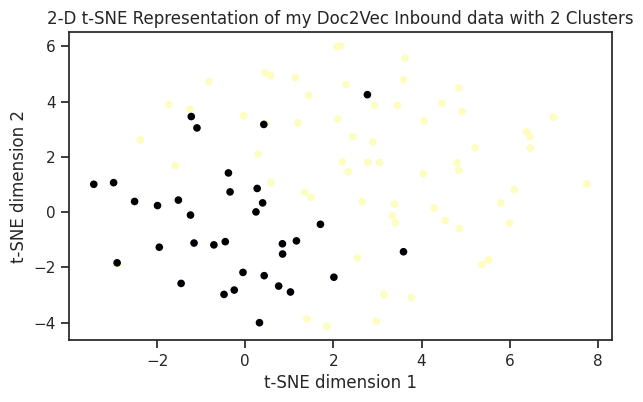

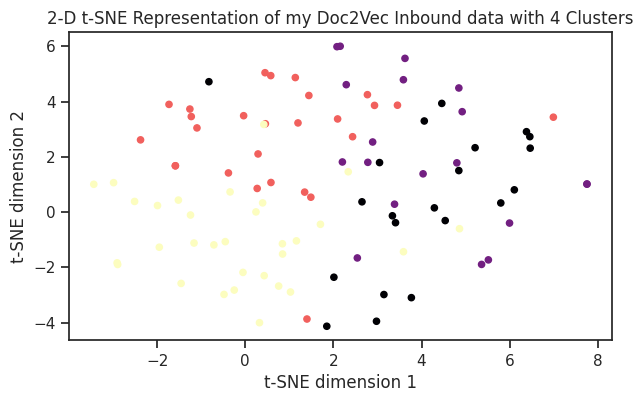

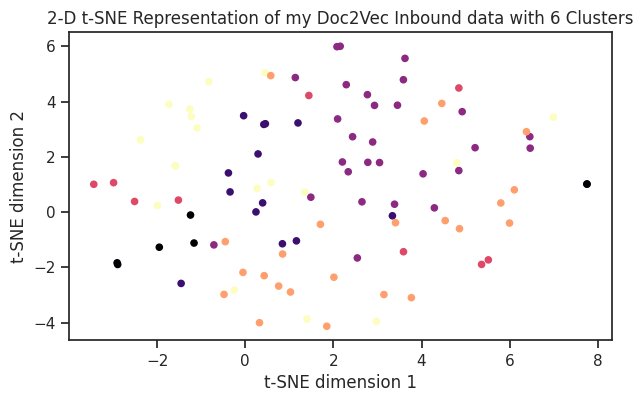

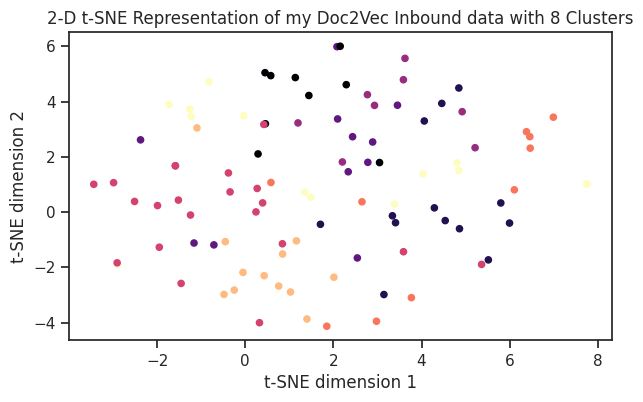

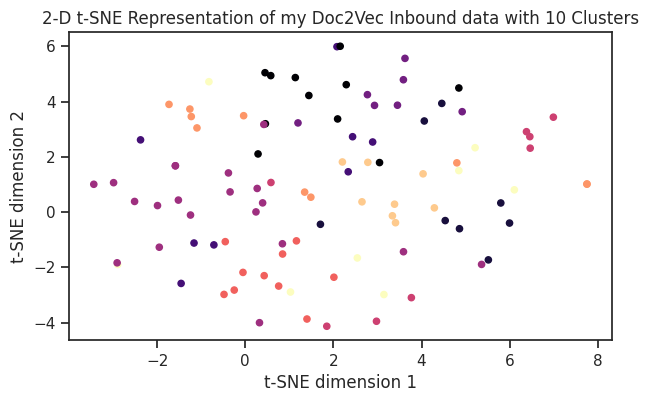

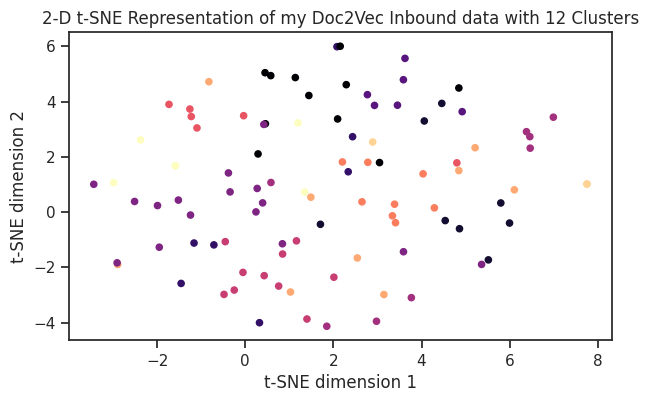

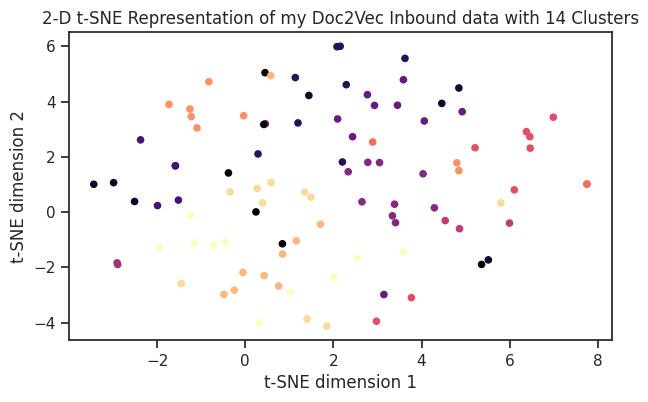

In [124]:
# Plotting my visualization for each of my n_neighbors, now with Doc2Vec embedded data

for k in range(2,16,2):
    # Getting the right K-Means cluster labels.
    labels = joblib.load(f'/kaggle/working/kmeans/inbound_cv_d2v-{str(k)}neighbors.sav').labels_
    
    # Visualize high-dimensional data
    plt.figure(figsize=(7,4))
    plt.scatter(inbound_d2v_tsne[:,0], inbound_d2v_tsne[:,1], s=20, c = labels, cmap = 'magma')
    plt.title(f'2-D t-SNE Representation of my Doc2Vec Inbound data with {k} Clusters')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.show()

In [125]:
# Storing it into objects I can use in this notebook

with open('objects:wcss_d2v.pkl', 'rb') as handle:
    wcss_d2v = pickle.load(handle)
with open('objects:labels_d2v.pkl','rb') as handle:
    labels_d2v = pickle.load(handle)
with open('objects:silhouette_scores_d2v.pkl','rb') as handle:
    silhouette_scores_d2v = pickle.load(handle)

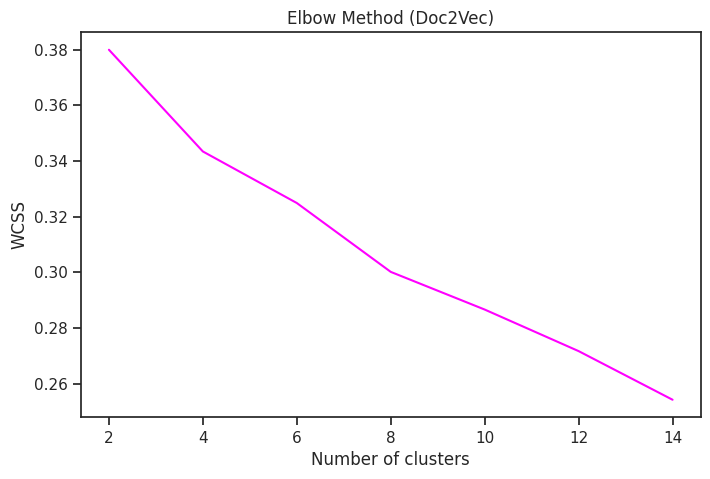

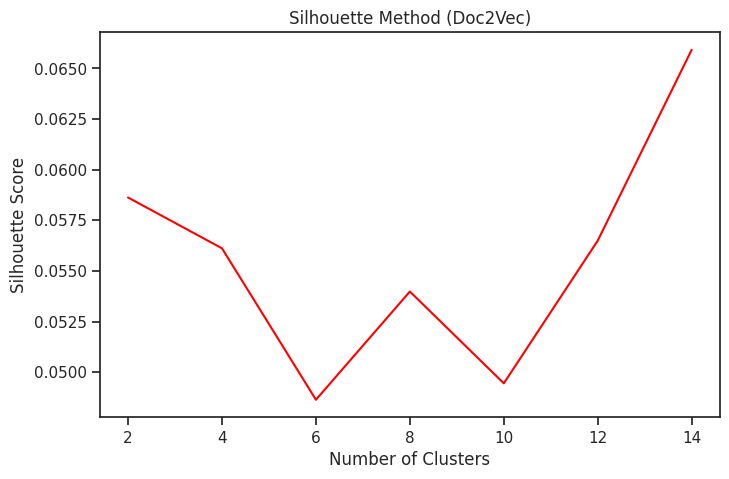

In [126]:
# Elbow Plot d2v
plt.figure(figsize=(8,5))
plt.plot(range(2,16,2), wcss_d2v['inbound_cv_d2v_wcss'], color = 'magenta')
plt.title('Elbow Method (Doc2Vec)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Silouette Plot d2v
plt.figure(figsize=(8,5))
plt.plot(range(2 ,16 ,2), silhouette_scores_d2v['inbound_cv_d2v_silhouettes'], color = 'red')
plt.title('Silhouette Method (Doc2Vec)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [128]:
string_processed_inbound

0               mean mental illness
1             mental illness affect
2              cause mental illness
3       warning sign mental illness
4     people mental illness recover
                  ...              
93                     know m drink
94      cannabis dangerous legalize
95            convince kid use drug
96    legal status evidence cbd oil
97                    evidence vape
Name: Real Inbound, Length: 98, dtype: object

## <font color = 'blue'>2. LDA (Latent Dirichlet Allocation) </color>
My second approach for the clustering is LDA topic modelling. It basically takes your data and splits it into topics. My goal is still to cluster, but with this method I hope to get more useful, distinct topics.

Useful articles:
* https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
* https://medium.com/nanonets/topic-modeling-with-lsa-psla-lda-and-lda2vec-555ff65b0b05

There are also newer, deep-learning based methods called LDA2Vec which could be interesting to explore as well.

However, due to prorities shifting, I will employ this step as a future step.

In [137]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Helper function to print topics
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Tweak the two parameters below
number_topics = 5
number_words = 10

# Create a CountVectorizer to convert text data to a document-term matrix
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
count_data = count_vectorizer.fit_transform(string_processed_inbound)

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)



Topics found via LDA:

Topic #0:
disorder difference personality anxiety use help problem depression substance selfhelp

Topic #1:
mental illness know use treatment need young parent involved thought

Topic #2:
help psychiatrist psychologist pay adult counsellor medication need doctor child

Topic #3:
health mental information care professional problem help child learn schizophrenia

Topic #4:
think medication mean support group worried counselling right cannabis adult


In [133]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))

# Ensure indentation for the following code block
if 1 == 1:
    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
    with open(LDAvis_data_filepath, 'wb') as f:  # Change 'w' to 'wb' for binary write mode
        pickle.dump(LDAvis_prepared, f)

# Load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:  # Change 'w' to 'rb' for binary read mode
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')


AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'